In [32]:
# !pip install transformers

# import libraries
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import datetime
import random
import spacy
from torch.utils.data import TensorDataset, DataLoader

#### Data Loading

In [33]:
df1=pd.read_csv("generic_sentiment_dataset_50k.csv")
df2=pd.read_csv("generic_sentiment_dataset_10k.csv")

# combine the two datasets
df = pd.concat([df1, df2], ignore_index=True)
print(df['label'].value_counts())


label
2    31421
0    16947
1    11632
Name: count, dtype: int64


In [34]:
# Take a subset of the data for faster processing
# 34500 rows of data from the original dataset
# 11500 rows for each of the 3 classes (positive, negative, neutral)
# set random seed for reproducibility

seed = 42
df_clean = df.dropna()  # drop rows with missing values
df_clean = df_clean.sample(frac=1).reset_index(drop=True)           # shuffle the data
df_clean = df_clean.groupby('sentiment').head(11500)          # take 11500 rows from each class
df_clean = df_clean.sample(frac=1).reset_index(drop=True)     # shuffle the data again
df_clean

,sentiment,text,label
0,positive,16lbs is still a huge achievement though,2
1,positive,Good,2
2,negative,Plz plz do not buy this phone..this is a jugad...,0
3,neutral,Good,1
4,positive,Design:\nI bought this phone in moonlight col...,2
...,...,...,...
34495,positive,Improve battery life but it's camera and finge...,2
34496,positive,has just finished reading Twilight and thought...,2
34497,negative,"Tuch working very poor, bad camera quality",0
34498,positive,"In the reporting period , the company 's opera...",2


#### Load preprocessed data

In [35]:
torch.cuda.empty_cache()

# Data splits
# -------------
# split the data into train, validation and test sets
seed1 = 42
seed2 = 52
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(df_clean.drop('label', axis=1), df_clean['label'], test_size=0.2, random_state=seed1)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=X_test.shape[0], random_state=seed2)

X_train_and_val_nn = X_train_and_val['text']
X_train_nn = X_train['text']
X_val_nn = X_val['text']
X_test_nn = X_test['text']

In [36]:
# check if there are any null values
print(X_train_and_val_nn.isnull().sum())
print(X_train_nn.isnull().sum())
print(X_val_nn.isnull().sum())
print(X_test_nn.isnull().sum())

0
0
0
0


### BERT Model (Optimized) - with Smart Padding
In order to improve over the previous model in terms of computatioal efficiency, smart padding technique is used where the padding is dynamically changed based on the length of the sequences.

In [37]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [38]:
tokens = []
labels = []
max_len = 256
update_interval = 1000

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(X_train_nn)))

# For each training example...
for text in tqdm(X_train_nn):
    # Report progress.
    if ((len(tokens) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(tokens)))
    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_len,
                                 truncation=True,
                                 padding=False)
    

    # Add the tokenized result to our list.
    tokens.append(input_ids)

print('DONE with {} samples'.format(len(tokens)))


Tokenizing 20,700 training samples...


  1%|▏         | 273/20700 [00:00<00:07, 2725.67it/s]

  Tokenized 0 samples.


  7%|▋         | 1412/20700 [00:00<00:07, 2690.93it/s]

  Tokenized 1,000 samples.


 13%|█▎        | 2736/20700 [00:01<00:07, 2509.67it/s]

  Tokenized 2,000 samples.


 17%|█▋        | 3588/20700 [00:01<00:06, 2687.08it/s]

  Tokenized 3,000 samples.


 23%|██▎       | 4687/20700 [00:01<00:06, 2647.84it/s]

  Tokenized 4,000 samples.


 27%|██▋       | 5525/20700 [00:02<00:05, 2727.01it/s]

  Tokenized 5,000 samples.


 31%|███       | 6407/20700 [00:02<00:05, 2780.55it/s]

  Tokenized 6,000 samples.


 35%|███▍      | 7238/20700 [00:02<00:05, 2537.75it/s]

  Tokenized 7,000 samples.


 40%|████      | 8374/20700 [00:03<00:04, 2688.99it/s]

  Tokenized 8,000 samples.


 46%|████▌     | 9456/20700 [00:03<00:04, 2561.24it/s]

  Tokenized 9,000 samples.


 51%|█████     | 10532/20700 [00:03<00:03, 2649.95it/s]

  Tokenized 10,000 samples.


 56%|█████▌    | 11579/20700 [00:04<00:03, 2551.02it/s]

  Tokenized 11,000 samples.


 60%|█████▉    | 12407/20700 [00:04<00:03, 2641.20it/s]

  Tokenized 12,000 samples.


 65%|██████▌   | 13490/20700 [00:05<00:02, 2655.74it/s]

  Tokenized 13,000 samples.


 69%|██████▉   | 14322/20700 [00:05<00:02, 2702.61it/s]

  Tokenized 14,000 samples.


 74%|███████▍  | 15388/20700 [00:05<00:02, 2516.39it/s]

  Tokenized 15,000 samples.


 79%|███████▉  | 16413/20700 [00:06<00:01, 2468.27it/s]

  Tokenized 16,000 samples.


 84%|████████▍ | 17438/20700 [00:06<00:01, 2512.71it/s]

  Tokenized 17,000 samples.


 88%|████████▊ | 18292/20700 [00:07<00:00, 2615.25it/s]

  Tokenized 18,000 samples.


 94%|█████████▎| 19364/20700 [00:07<00:00, 2620.78it/s]

  Tokenized 19,000 samples.


 99%|█████████▉| 20455/20700 [00:07<00:00, 2691.20it/s]

  Tokenized 20,000 samples.


100%|██████████| 20700/20700 [00:07<00:00, 2607.76it/s]

DONE with 20700 samples


In [39]:
# Sort training samples by the length of their input sequence.
train_samples = sorted(zip(tokens, y_train), key=lambda x: len(x[0]))
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 256


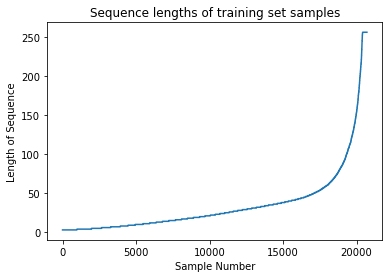

In [40]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

# Plot the sequence lengths for visualization.
plt.plot(range(0, len(sorted_lengths)), sorted_lengths)
plt.xlabel('Sample Number')
plt.ylabel('Length of Sequence')
plt.title('Sequence lengths of training set samples')
plt.show()

In [41]:
def create_smart_padded_batches(text_samples, labels, batch_size, max_len = 256):
    print('Forming smart batches from {} examples. Batch size {}\n'.format(len(text_samples), batch_size))
    # ------------------------------------------------------------------
    # First tokenize all the samples and truncate them to a max length.
    # ------------------------------------------------------------------
    tokenized_inputs = []
    for sample in tqdm(text_samples):
        # Tokenize the sample
        tokenized_input = tokenizer.encode(text=sample,
                                     add_special_tokens=True,
                                     max_length=max_len,
                                     truncation=True,
                                     padding=False)
        # Add to list
        tokenized_inputs.append(tokenized_input)
    print('Finished tokenizing: {:>10,} samples\n'.format(len(tokenized_inputs)))

    # ---------------------------------------------------------------------
    # Batch the tokenized sequences together after sorting them by length.
    # ---------------------------------------------------------------------
    sorted_samples_labels = sorted(zip(tokenized_inputs, labels), key=lambda x: len(x[0]))

    # Create lists of batches of samples and labels.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    # Loop over the input samples until it is empty
    while len(sorted_samples_labels) > 0:
        # Print progress after 500 batches.
        if ((len(batch_ordered_sentences) % 500) == 0):
            print(' Finished {:,} batches.'.format(len(batch_ordered_sentences)))

        # num_samples_to_pick = normally batch size, for the last batch it will be the remaining samples
        num_samples_to_pick = min(batch_size, len(sorted_samples_labels))

        # Start at a random point in the list of samples and choose num_samples_to_pick contiguous samples
        start = random.randint(0, len(sorted_samples_labels) - num_samples_to_pick)
        batch = sorted_samples_labels[start:start + num_samples_to_pick]

        # Split the (samples, labels) tuples into samples and labels
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the original list of training samples.
        del sorted_samples_labels[start:start + num_samples_to_pick]
    print('\n  Finished processing {:,} batches.'.format(len(batch_ordered_sentences)))

    # --------------
    #  Add Padding
    # --------------
    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):
        # Lists of padded inputs and masks
        batch_padded_inputs = []
        batch_attn_masks = []

        # Get the longest sequence size in the current batch
        max_size = max([len(sen) for sen in batch_inputs])

        # Pad the sequences uptp the max_size and also create the attention masks.
        for sen in batch_inputs:
            padding_count = max_size - len(sen)
            # Add the token for padding at the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*padding_count
            # Create the attention mask with 1 for real tokens and 0 for padding tokens.
            attn_mask = [1] * len(sen) + [0] * padding_count
            # Add these to the lists.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Convert to tensors and add to the lists.
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('Finished Padding.')
    token_count_padded = 0
    for batch in py_inputs:
        for sen in batch:
            token_count_padded += len(sen)
    token_count_fixed = max_len * len(py_inputs) * batch_size
    print('  Number of tokens with fixed padding: {}'.format(token_count_fixed))
    print('  Number of tokens with smart padding: {}'.format(token_count_padded))
    print('  Percentage reduction in tokens is: {:,.2f}%'.format(100*(token_count_fixed-token_count_padded)/token_count_fixed))

    # Return the dataset
    return (py_inputs, py_attn_masks, py_labels)

In [42]:
def format_time(elapsed):
    # Return time as string hh:mm:ss
    time_int = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=time_int))

In [43]:
# Create config and network for multiclass sequence classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
                                    num_labels=3)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path='bert-base-uncased',
    config=config)

print('Config:', str(type(config)), '\n')
print('Model type:', str(type(model)))

# Load the model on the GPU
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

desc = model.to(device)
print('DONE.')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Config: <class 'transformers.models.bert.configuration_bert.BertConfig'> 

Model type: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>
DONE.


In [44]:
# Define the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-6, eps = 1e-8)

batch_size = 8
epochs = 4

# Max length for tokenization
max_len = 256

# Perform tokenization and smart batching on the training data
(py_inputs, py_attn_masks, py_labels) = create_smart_padded_batches(X_train_nn, y_train, batch_size, max_len)
total_steps = len(py_inputs) * epochs   # training_steps = [number of batches] x [number of epochs].

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Forming smart batches from 20700 examples. Batch size 8



100%|██████████| 20700/20700 [00:07<00:00, 2625.10it/s]


Finished tokenizing:     20,700 samples

 Finished 0 batches.
 Finished 500 batches.
 Finished 1,000 batches.
 Finished 1,500 batches.
 Finished 2,000 batches.
 Finished 2,500 batches.

  Finished processing 2,588 batches.
Finished Padding.
  Number of tokens with fixed padding: 5300224
  Number of tokens with smart padding: 735624
  Percentage reduction in tokens is: 86.12%


In [45]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# Set the seed value all over the place to make this reproducible.
seed_val = 87
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in tqdm(range(0, epochs)):
    # ========================================
    #               Training
    # ========================================
    print('\n=== Epoch {:} / {:} ==='.format(epoch_i + 1, epochs))

    # Randomnize the training set, i.e smart batch again
    if epoch_i > 0:
        (py_inputs, py_attn_masks, py_labels) = create_smart_padded_batches(X_train_nn, y_train, batch_size, max_len)
    print('Training on {:} batches...'.format(len(py_inputs)))

    start_time = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step in tqdm(range(0, len(py_inputs))):
        # Copy the current training batch to the GPU.
        batch_input_ids = py_inputs[step].to(device)
        batch_input_mask = py_attn_masks[step].to(device)
        batch_labels = py_labels[step].to(device)

        # Clear gradients
        model.zero_grad()
        # Forward pass
        result = model(
            batch_input_ids,
            token_type_ids=None,
            attention_mask=batch_input_mask,
            labels=batch_labels)

        # Compute training loss and accumulate
        loss = result.loss
        total_train_loss += loss.item()
        # Backward pass
        loss.backward()

        # To prevent exploding gradinets problem, clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update the parameters and the learning rate.
        optimizer.step()
        scheduler.step()
    # Calculate the average training loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - start_time)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    print("\nRunning Validation...")
    (py_val_inputs, py_val_attn_masks, py_val_labels) = create_smart_padded_batches(X_val_nn, y_val, batch_size, max_len)

    # Tracking variables
    predictions , true_labels = [], []

    # model.eval()
    total_val_loss = 0
    # For each batch of validation
    for step in range(0, len(py_val_inputs)):
        # Copy the batch to the GPU.
        batch_input_ids_val = py_val_inputs[step].to(device)
        batch_input_mask_val = py_val_attn_masks[step].to(device)
        batch_labels_val = py_val_labels[step].to(device)

        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(batch_input_ids_val, token_type_ids=None,
                            attention_mask=batch_input_mask_val, labels=batch_labels_val)
        total_val_loss += outputs.loss
        logits = outputs.logits
        # compute validation loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels_val.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Combine the results across the batches.
    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    # Choose the label with the highest score as our prediction.
    preds = np.argmax(predictions, axis=1).flatten()

    f1 = f1_score(true_labels, preds, average='macro')
    # Calculate the average val loss over all of the batches.
    avg_val_loss = total_val_loss / len(py_val_inputs)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
            'validation loss': avg_val_loss,
            'validation F1 score': f1
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  0%|          | 0/4 [00:00<?, ?it/s]


=== Epoch 1 / 4 ===
Training on 2588 batches...


100%|██████████| 2588/2588 [05:01<00:00,  8.57it/s]



  Average training loss: 0.82
  Training epcoh took: 0:05:02

Running Validation...
Forming smart batches from 6900 examples. Batch size 8



100%|██████████| 6900/6900 [00:03<00:00, 2182.99it/s]


Finished tokenizing:      6,900 samples

 Finished 0 batches.
 Finished 500 batches.

  Finished processing 863 batches.
Finished Padding.
  Number of tokens with fixed padding: 1767424
  Number of tokens with smart padding: 250064
  Percentage reduction in tokens is: 85.85%


 25%|██▌       | 1/4 [05:22<16:07, 322.64s/it]


=== Epoch 2 / 4 ===
Forming smart batches from 20700 examples. Batch size 8



100%|██████████| 20700/20700 [00:09<00:00, 2169.48it/s]


Finished tokenizing:     20,700 samples

 Finished 0 batches.
 Finished 500 batches.
 Finished 1,000 batches.
 Finished 1,500 batches.
 Finished 2,000 batches.
 Finished 2,500 batches.

  Finished processing 2,588 batches.
Finished Padding.
  Number of tokens with fixed padding: 5300224
  Number of tokens with smart padding: 735128
  Percentage reduction in tokens is: 86.13%
Training on 2588 batches...


100%|██████████| 2588/2588 [05:07<00:00,  8.41it/s]



  Average training loss: 0.68
  Training epcoh took: 0:05:08

Running Validation...
Forming smart batches from 6900 examples. Batch size 8



100%|██████████| 6900/6900 [00:03<00:00, 1898.14it/s]


Finished tokenizing:      6,900 samples

 Finished 0 batches.
 Finished 500 batches.

  Finished processing 863 batches.
Finished Padding.
  Number of tokens with fixed padding: 1767424
  Number of tokens with smart padding: 247536
  Percentage reduction in tokens is: 85.99%


 50%|█████     | 2/4 [11:01<11:04, 332.38s/it]


=== Epoch 3 / 4 ===
Forming smart batches from 20700 examples. Batch size 8



100%|██████████| 20700/20700 [00:11<00:00, 1847.13it/s]


Finished tokenizing:     20,700 samples

 Finished 0 batches.
 Finished 500 batches.
 Finished 1,000 batches.
 Finished 1,500 batches.
 Finished 2,000 batches.
 Finished 2,500 batches.

  Finished processing 2,588 batches.
Finished Padding.
  Number of tokens with fixed padding: 5300224
  Number of tokens with smart padding: 736120
  Percentage reduction in tokens is: 86.11%
Training on 2588 batches...


100%|██████████| 2588/2588 [05:11<00:00,  8.31it/s]



  Average training loss: 0.64
  Training epcoh took: 0:05:11

Running Validation...
Forming smart batches from 6900 examples. Batch size 8



100%|██████████| 6900/6900 [00:03<00:00, 1935.73it/s]


Finished tokenizing:      6,900 samples

 Finished 0 batches.
 Finished 500 batches.

  Finished processing 863 batches.
Finished Padding.
  Number of tokens with fixed padding: 1767424
  Number of tokens with smart padding: 247488
  Percentage reduction in tokens is: 86.00%


 75%|███████▌  | 3/4 [16:46<05:38, 338.04s/it]


=== Epoch 4 / 4 ===
Forming smart batches from 20700 examples. Batch size 8



100%|██████████| 20700/20700 [00:10<00:00, 1960.46it/s]


Finished tokenizing:     20,700 samples

 Finished 0 batches.
 Finished 500 batches.
 Finished 1,000 batches.
 Finished 1,500 batches.
 Finished 2,000 batches.
 Finished 2,500 batches.

  Finished processing 2,588 batches.
Finished Padding.
  Number of tokens with fixed padding: 5300224
  Number of tokens with smart padding: 736600
  Percentage reduction in tokens is: 86.10%
Training on 2588 batches...


100%|██████████| 2588/2588 [05:07<00:00,  8.41it/s]



  Average training loss: 0.63
  Training epcoh took: 0:05:08

Running Validation...
Forming smart batches from 6900 examples. Batch size 8



100%|██████████| 6900/6900 [00:03<00:00, 1812.87it/s]


Finished tokenizing:      6,900 samples

 Finished 0 batches.
 Finished 500 batches.

  Finished processing 863 batches.
Finished Padding.
  Number of tokens with fixed padding: 1767424
  Number of tokens with smart padding: 248156
  Percentage reduction in tokens is: 85.96%


100%|██████████| 4/4 [22:27<00:00, 336.81s/it]


Training complete!
Total training took 0:22:27 (h:mm:ss)


In [46]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.8171782934522887,
  'Training Time': '0:05:02',
  'validation loss': tensor(0.7340, device='cuda:0'),
  'validation F1 score': 0.6780297446035916},
 {'epoch': 2,
  'Training Loss': 0.6830918176741652,
  'Training Time': '0:05:08',
  'validation loss': tensor(0.7037, device='cuda:0'),
  'validation F1 score': 0.6930339363610306},
 {'epoch': 3,
  'Training Loss': 0.6438738309232722,
  'Training Time': '0:05:11',
  'validation loss': tensor(0.6955, device='cuda:0'),
  'validation F1 score': 0.6957078817369213},
 {'epoch': 4,
  'Training Loss': 0.625170377473213,
  'Training Time': '0:05:08',
  'validation loss': tensor(0.6922, device='cuda:0'),
  'validation F1 score': 0.6994341574811945}]

By checking the validation loss, we stop the training here to avoid overfitting.

In [47]:
# Evaluate on the test split
(py_test_inputs, py_test_attn_masks, py_test_labels) = create_smart_padded_batches(X_test_nn, y_test, batch_size)

Forming smart batches from 6900 examples. Batch size 8



100%|██████████| 6900/6900 [00:03<00:00, 2055.61it/s]


Finished tokenizing:      6,900 samples

 Finished 0 batches.
 Finished 500 batches.

  Finished processing 863 batches.
Finished Padding.
  Number of tokens with fixed padding: 1767424
  Number of tokens with smart padding: 240088
  Percentage reduction in tokens is: 86.42%


In [48]:
# Prediction on test set with the best model
print('Predicting labels for {:,} test batches ...'.format(len(py_test_labels)))
model.eval()
predictions , true_labels = [], []

# For each batch of test
for step in range(0, len(py_test_inputs)):
    # Copy the batch to the GPU.
    b_input_ids = py_test_inputs[step].to(device)
    b_input_mask = py_test_attn_masks[step].to(device)
    b_labels = py_test_labels[step].to(device)

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, preds, average='macro')
print('F1 score: {:.3f}'.format(f1))

Predicting labels for 863 test batches ...
    DONE.
Accuracy: 0.716
F1 score: 0.715


#### Saving the best model

In [49]:
# Save the model and tokenizer - This is the best model
model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_tokenizer")

('bert_tokenizer\\tokenizer_config.json',
 'bert_tokenizer\\special_tokens_map.json',
 'bert_tokenizer\\vocab.txt',
 'bert_tokenizer\\added_tokens.json')

### Final prediction
Predicting on the outputs of the different chatbot LLMs
Treating BERT predictions as ground truth labels and the tones predicted by the chatbot LLMs as the predicted labels.

In [62]:
torch.cuda.empty_cache()

# Load the model and tokenizer from the saved directory
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained("bert_model/")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)  # Move the model to the same device as input tensors

# set model to evaluate mode
model.eval()

# Load the tokenizer from the saved directory
tokenizer = BertTokenizer.from_pretrained("bert_tokenizer/")

In [71]:
max_len = 256 # put that we chose during training

# test file generated from the models
test_data_files = ["tone_analysis_data_gpt.csv",
"tone_analysis_data_gptlc.csv",
"tone_analysis_data_alpaca.csv",
"tone_analysis_data_hc1.csv",
"tone_analysis_data_bard.csv"]

results_dict = {}

for test_file in test_data_files:
    chatbot_name = test_file.split('_')[3].split('.')[0]
    print('Predicting for chatbot: {}'.format(chatbot_name))

    df_test = pd.read_csv(test_file, encoding="cp1252")

    # tokenize the reviews
    test_encodings = tokenizer(list(df_test['text']), truncation=True, padding=True, max_length=max_len, return_tensors='pt', add_special_tokens=True)
    print('Finished tokenizing: {:>10,} samples\n'.format(len(test_encodings)))

    # create dataset loaders for ease of use
    test_dataset = TensorDataset(test_encodings.input_ids, test_encodings.attention_mask)
    test_loader = DataLoader(test_dataset, batch_size=16)

    predictions = []
    with torch.no_grad():
        for batch in tqdm(test_loader):
            # get a batch
            input_ids, attention_mask = batch
            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            # predict
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=None)
            logits = outputs.logits
            # store logits
            predictions.append(logits.cpu())
    
    # concatenate results from all batches
    predictions = np.concatenate(predictions, axis=0)
    # ground truth labels are argmax of logits as predicted by BERT
    bert_labels = np.argmax(predictions, axis=1).flatten()

    # create a dataframe with the predictions and the ground truth labels
    results = pd.DataFrame()
    results['model_labels'] = df_test['label'] 
    results['bert_labels'] = bert_labels

    results_dict[chatbot_name] = results

Predicting for chatbot: gpt
Finished tokenizing:          3 samples



100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


Predicting for chatbot: gptlc
Finished tokenizing:          3 samples



100%|██████████| 2/2 [00:00<00:00, 49.99it/s]


Predicting for chatbot: alpaca
Finished tokenizing:          3 samples



100%|██████████| 2/2 [00:00<00:00, 49.94it/s]


Predicting for chatbot: hc1
Finished tokenizing:          3 samples



100%|██████████| 2/2 [00:00<00:00, 35.70it/s]


Predicting for chatbot: bard
Finished tokenizing:          3 samples



100%|██████████| 2/2 [00:00<00:00, 39.58it/s]


In [72]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

for chatbot_name, results in results_dict.items():
    print(chatbot_name)
    print('----------------')
    cmat = confusion_matrix(results['bert_labels'], results['model_labels'])
    print("confusion_matrix:\n", cmat)
    print("accuracy: ", accuracy_score(results['bert_labels'], results['model_labels']))
    print("f1 score: ", f1_score(results['bert_labels'], results['model_labels'], average='macro'))
    print('\n')

gpt
----------------
confusion_matrix:
 [[0 0 0]
 [5 3 1]
 [1 3 5]]
accuracy:  0.4444444444444444
f1 score:  0.3555555555555556


gptlc
----------------
confusion_matrix:
 [[2 2 0]
 [4 3 1]
 [0 1 5]]
accuracy:  0.5555555555555556
f1 score:  0.5539682539682539


alpaca
----------------
confusion_matrix:
 [[1 0 0]
 [4 4 3]
 [1 2 3]]
accuracy:  0.4444444444444444
f1 score:  0.41876750700280113


hc1
----------------
confusion_matrix:
 [[2 0 0]
 [4 5 2]
 [0 1 4]]
accuracy:  0.6111111111111112
f1 score:  0.605169340463458


bard
----------------
confusion_matrix:
 [[3 1 0]
 [2 5 3]
 [1 0 3]]
accuracy:  0.6111111111111112
f1 score:  0.6083333333333334


